# COGS 118A - Final Project

# Model Selection

In [1]:
# import all necessary packages and formulas

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn import svm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import *
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
# Run our notebook to generate the dataframe

%run web_scraper_and_cleaning.ipynb

[Link to Web Scraping and Data Cleaning Notebook](web_scraper_and_cleaning.ipynb)

In [3]:
# Assign dataframe to the merged dataframe created in the web scraping notebook

df = merged_df

In [4]:
# create column of class labels, 1 for All NBA, 0 for not

df['all_nba'] = np.where(df['all_nba_team'] >= 1, 1, 0)

In [5]:
# add a points per game column
df['PTS/G'] = (df.PTS / df.G).round(decimals=1)

In [6]:
# gather numeric columns

numeric_columns = ['Age', 'G', 'GS', 'MP', 'FG', '3P', 'eFG%', 'FT', 'TRB', 'AST', 
                   'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PTS/G', 'all_nba']

In [7]:
df = df.drop(['FGA', 'FG%', '3PA', '3P%', '2P', '2PA', '2P%', 'FT%', 'FTA', 'ORB', 'DRB'], axis=1)

## Baseline Classification

In [8]:
# Split dataset

X_train, X_test, y_train, y_test = train_test_split(df[numeric_columns].drop(columns='all_nba')[df.Year != 2022], 
                                                    df.all_nba[df.Year != 2022], 
    test_size=.33, random_state=42, stratify=df.all_nba[df.Year != 2022])

In [9]:
print('The shape of the X_train is:', X_train.shape)
print('The shape of the X_test is:', X_test.shape)
print('The shape of the y_train is:', y_train.shape)
print('The shape of the y_test is:', y_test.shape)

The shape of the X_train is: (7495, 16)
The shape of the X_test is: (3693, 16)
The shape of the y_train is: (7495,)
The shape of the y_test is: (3693,)


In [10]:
dummy_clf = DummyClassifier(strategy='most_frequent').fit(df[numeric_columns].drop(columns='all_nba')[df.Year != 2022],
                                                          df.all_nba[df.Year != 2022])
stratified_dummy_clf = DummyClassifier(strategy='stratified').fit(df[numeric_columns].drop(columns='all_nba')[df.Year != 2022],
                                                          df.all_nba[df.Year != 2022])

In [11]:
dummy_clf.fit(X_train, y_train)
stratified_dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

In [12]:
print('Most frequent class guessing in baseline gives: ' + str(dummy_clf.score(X_test, y_test)))
print('Stratified class guessing in baseline gives: ' + str(stratified_dummy_clf.score(X_test, y_test)))

Most frequent class guessing in baseline gives: 0.9558624424587057
Stratified class guessing in baseline gives: 0.9160574059030598


## Model Selection - Logistic Regression

In [13]:
# Estimator and pipeline for logistic regression

log_clf = LogisticRegression(random_state=42)

pipe = Pipeline([('scaler', StandardScaler()), ('classifier', log_clf)])

In [14]:
# Parameter grid for logistic regression

log_param = {}
log_param['classifier__C'] = np.logspace(-3,3,7)
log_param['classifier__penalty'] = ['none','l1', 'l2']
log_param['classifier__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
log_param['classifier__class_weight'] = [None, 'balanced', {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
log_param['classifier'] = [log_clf]

In [15]:
# Grid search

log_grid = GridSearchCV(pipe, log_param, cv=3, n_jobs=-1, scoring='f1_micro', verbose=3).fit(X_train, y_train)

Fitting 3 folds for each of 315 candidates, totalling 945 fits


C:\Users\kylec\Documents\Programming\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
315 fits failed out of a total of 945.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kylec\Documents\Programming\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kylec\Documents\Programming\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\kylec\Documents\Programming\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
   

Here we have certain fits failing due to some of our solver parameters not being able to use certain penalties, this was expected.

In [16]:
log_grid.best_params_

{'classifier': LogisticRegression(C=10.0, random_state=42, solver='liblinear'),
 'classifier__C': 10.0,
 'classifier__class_weight': None,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear'}

In [17]:
log_grid.best_score_

0.9766510287061182

In [18]:
df_2022 = df[df['Year']==2022]

In [19]:
log_grid.score(df_2022[numeric_columns].drop(columns='all_nba'), df_2022['all_nba'])

0.9824120603015075

In [20]:
df_2022['all_nba_pred'] = log_grid.predict(df_2022[numeric_columns].drop(columns='all_nba'))

df_2022[df_2022['all_nba_pred'] == 1][['all_nba', 'all_nba_pred']].head(30)

,all_nba,all_nba_pred
Player,,
Giannis Antetokounmpo,1,1
Jimmy Butler,0,1
Stephen Curry,1,1
DeMar DeRozan,1,1
Luka Dončić,1,1
Kevin Durant,1,1
Joel Embiid,1,1
Rudy Gobert,0,1
James Harden,0,1


In [21]:
df_2022['all_nba_prob'] = log_grid.predict_proba(df_2022[numeric_columns].drop(columns='all_nba'))[:,1]

df_2022[['all_nba', 'all_nba_pred', 'all_nba_prob']].sort_values('all_nba_prob', ascending = False).head(20)

,all_nba,all_nba_pred,all_nba_prob
Player,,,
Nikola Jokić,1,1,0.999007
Giannis Antetokounmpo,1,1,0.997597
Joel Embiid,1,1,0.996971
LeBron James,1,1,0.985786
Kevin Durant,1,1,0.974971
Trae Young,1,1,0.953575
Luka Dončić,1,1,0.937479
DeMar DeRozan,1,1,0.919536
Rudy Gobert,0,1,0.906054


## Model Selection - KNN

In [27]:
knn = KNeighborsClassifier()
k_range = list(range(1, 31,2))

param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(knn, param_grid, cv=10, scoring='roc_auc', return_train_score=False,verbose=1)
grid_search = grid.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


In [28]:
print(grid_search.best_params_)

{'n_neighbors': 29}


In [29]:
print(grid_search.best_score_)

0.9772180110143243


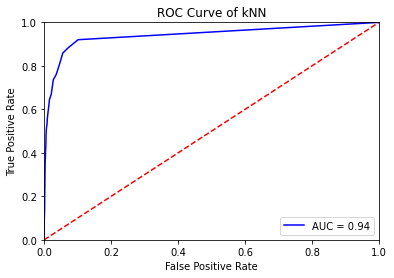

In [30]:
knn = KNeighborsClassifier(n_neighbors = 29)
knn.fit(X_train,y_train)

y_scores = knn.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [31]:
print('Precision:', precision_score(grid_search.predict(X_test), y_test))
print('Recall:', recall_score(grid_search.predict(X_test), y_test))
print('Roc_Auc_score:', roc_auc_score(grid_search.predict(X_test), y_test))

Precision: 0.44171779141104295
Recall: 0.8
Roc_Auc_score: 0.8873716347488204


In [32]:
df_2022 = df[df['Year']==2022]

In [33]:
grid_search.score(df_2022[numeric_columns].drop(columns='all_nba'), df_2022['all_nba'])

0.990426457789382

In [34]:
df_2022['all_nba_pred'] = grid_search.predict(df_2022[numeric_columns].drop(columns='all_nba'))

df_2022[df_2022['all_nba_pred'] == 1][['all_nba', 'all_nba_pred']].head(30)

,all_nba,all_nba_pred
Player,,
Giannis Antetokounmpo,1,1
DeMar DeRozan,1,1
Luka Dončić,1,1
Joel Embiid,1,1
LeBron James,1,1
Nikola Jokić,1,1
Jayson Tatum,1,1
Karl-Anthony Towns,1,1
Trae Young,1,1


In [35]:
df_2022['all_nba_prob'] = grid_search.predict_proba(df_2022[numeric_columns].drop(columns='all_nba'))[:,1]

df_2022[['all_nba', 'all_nba_pred', 'all_nba_prob']].sort_values('all_nba_prob', ascending = False).head(20)

,all_nba,all_nba_pred,all_nba_prob
Player,,,
Nikola Jokić,1,1,0.931034
Trae Young,1,1,0.896552
Joel Embiid,1,1,0.862069
DeMar DeRozan,1,1,0.793103
Giannis Antetokounmpo,1,1,0.793103
Luka Dončić,1,1,0.758621
Jayson Tatum,1,1,0.758621
Karl-Anthony Towns,1,1,0.655172
LeBron James,1,1,0.551724


## Model Selection - SVM

In [48]:
C_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-2, 2, 5)
parameters = {'kernel':('linear', 'rbf'), 'C':C_range, 'gamma':gamma_range}
svc = svm.SVC(probability=True)

grid2 = GridSearchCV(svc, parameters, cv=3, n_jobs=-1, scoring=['roc_auc', 'precision', 'f1'], 
                  refit='precision', verbose=3)

grid_search2 = grid2.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [49]:
grid_search2.best_params_

{'C': 0.01, 'gamma': 0.01, 'kernel': 'linear'}

In [50]:
grid_search2.best_score_

0.8110640653106408

In [51]:
# Test set metric scores

print("Precision:",precision_score(grid_search2.predict(X_test), y_test))
print("Recall:",recall_score(grid_search2.predict(X_test), y_test))
print("ROC AUC Score:",roc_auc_score(grid_search2.predict(X_test), y_test))

Precision: 0.5644171779141104
Recall: 0.8363636363636363
ROC AUC Score: 0.9082739197726638


In [52]:
df_2022 = df[df['Year']==2022]

In [53]:
grid_search2.score(df_2022[numeric_columns].drop(columns='all_nba'), df_2022['all_nba'])

0.8125

In [54]:
df_2022['all_nba_pred'] = grid_search2.predict(df_2022[numeric_columns].drop(columns='all_nba'))

df_2022[df_2022['all_nba_pred'] == 1][['all_nba', 'all_nba_pred']].head(30)

,all_nba,all_nba_pred
Player,,
Giannis Antetokounmpo,1,1
Devin Booker,1,1
Jimmy Butler,0,1
Stephen Curry,1,1
DeMar DeRozan,1,1
Luka Dončić,1,1
Kevin Durant,1,1
Joel Embiid,1,1
James Harden,0,1


In [55]:
df_2022['all_nba_prob'] = grid_search2.predict_proba(df_2022[numeric_columns].drop(columns='all_nba'))[:,1]

df_2022[['all_nba', 'all_nba_pred', 'all_nba_prob']].sort_values('all_nba_prob', ascending = False).head(20)

,all_nba,all_nba_pred,all_nba_prob
Player,,,
Nikola Jokić,1,1,0.999987
Joel Embiid,1,1,0.996352
Giannis Antetokounmpo,1,1,0.995834
LeBron James,1,1,0.953895
Trae Young,1,1,0.935650
Luka Dončić,1,1,0.929972
DeMar DeRozan,1,1,0.920286
Kevin Durant,1,1,0.912629
James Harden,0,1,0.867358


## Model Selection - Random Forest

In [59]:
rfc=RandomForestClassifier(random_state=42, n_jobs = -1)

param_grid = { 
    'n_estimators': [200, 400, 600], #[200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5, 10, 20], #[4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid = param_grid, cv= 3, n_jobs = -1).fit(X_train, y_train)

In [60]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'n_estimators': 200}

In [61]:
CV_rfc.best_score_

0.9753171084286397

In [62]:
# Test set metric scores

print("Precision:",precision_score(CV_rfc.predict(X_test), y_test))
print("Recall:",recall_score(CV_rfc.predict(X_test), y_test))
print("ROC AUC Score:",roc_auc_score(CV_rfc.predict(X_test), y_test))

Precision: 0.5766871165644172
Recall: 0.7899159663865546
ROC AUC Score: 0.8853049333891362


In [63]:
df_2022 = df[df['Year']==2022]

In [64]:
CV_rfc.score(df_2022[numeric_columns].drop(columns='all_nba'), df_2022['all_nba'])

0.9874371859296482

In [65]:
df_2022['all_nba_pred'] = CV_rfc.predict(df_2022[numeric_columns].drop(columns='all_nba'))

df_2022[df_2022['all_nba_pred'] == 1][['all_nba', 'all_nba_pred']].head(30)

,all_nba,all_nba_pred
Player,,
Giannis Antetokounmpo,1,1
DeMar DeRozan,1,1
Luka Dončić,1,1
Kevin Durant,1,1
Joel Embiid,1,1
Rudy Gobert,0,1
LeBron James,1,1
Nikola Jokić,1,1
Ja Morant,1,1


In [66]:
df_2022['all_nba_prob'] = CV_rfc.predict_proba(df_2022[numeric_columns].drop(columns='all_nba'))[:,1]

df_2022[['all_nba', 'all_nba_pred', 'all_nba_prob']].sort_values('all_nba_prob', ascending = False).head(20)

,all_nba,all_nba_pred,all_nba_prob
Player,,,
Giannis Antetokounmpo,1,1,0.960
Nikola Jokić,1,1,0.940
Joel Embiid,1,1,0.940
DeMar DeRozan,1,1,0.905
Luka Dončić,1,1,0.850
Kevin Durant,1,1,0.825
Trae Young,1,1,0.790
Jayson Tatum,1,1,0.785
LeBron James,1,1,0.745


## Multiple Classifier Grid Search

In [71]:
# estimators for grid search

rf_clf = RandomForestClassifier(random_state=42)
sv_clf = svm.SVC(probability=True, random_state=42)
log_clf = LogisticRegression(random_state=42)
knn_clf = KNeighborsClassifier()

In [72]:
# Initiaze the hyperparameters for each dictionary


rf_param = {}
rf_param['classifier__n_estimators'] = [10, 50, 100, 250, 500]
rf_param['classifier__max_depth'] = [5, 10, 20]
rf_param['classifier__max_features'] = ['auto', 'sqrt', 'log2']
rf_param['classifier__class_weight'] = [None, 'balanced', {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
rf_param['classifier'] = [rf_clf]

sv_param = {}
sv_param['classifier__C'] = np.logspace(-2, 2, 5)
sv_param['classifier__class_weight'] = [None, 'balanced', {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
sv_param['classifier__gamma'] = np.logspace(-2, 2, 5)
sv_param['classifier__kernel'] = ['linear', 'rbf']
sv_param['classifier'] = [sv_clf]

log_param = {}
log_param['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
log_param['classifier__penalty'] = ['none', 'l2']
log_param['classifier__class_weight'] = [None, 'balanced', {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
log_param['classifier'] = [log_clf]

knn_param = {}
knn_param['classifier__n_neighbors'] = list(range(1, 31,2))
knn_param['classifier'] = [knn_clf]

In [73]:
pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', rf_clf)])
params = [rf_param, knn_param, sv_param, log_param]

In [74]:
%%time

# Train the grid search model
gs = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring=('f1_micro', 'roc_auc', 'precision'), 
                  refit='precision', verbose=3).fit(X_train, y_train)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Wall time: 7min 11s


In [75]:
gs.best_params_

{'classifier': SVC(C=0.1, gamma=0.01, probability=True, random_state=42),
 'classifier__C': 0.1,
 'classifier__class_weight': None,
 'classifier__gamma': 0.01,
 'classifier__kernel': 'rbf'}

In [76]:
gs.best_score_

0.9577308656256025

In [77]:
# Test set metric scores

print("Precision:",precision_score(gs.predict(X_test), y_test))
print("Recall:",recall_score(gs.predict(X_test), y_test))
print("ROC AUC Score:",roc_auc_score(gs.predict(X_test), y_test))

Precision: 0.27607361963190186
Recall: 0.8333333333333334
ROC AUC Score: 0.9004534212695796


In [78]:
df_2022 = df[df['Year']==2022]

In [79]:
gs.score(df_2022[numeric_columns].drop(columns='all_nba'), df_2022['all_nba'])

1.0

In [80]:
df_2022['all_nba_pred'] = gs.predict(df_2022[numeric_columns].drop(columns='all_nba'))

df_2022[df_2022['all_nba_pred'] == 1][['all_nba', 'all_nba_pred']].head(30)

,all_nba,all_nba_pred
Player,,
Giannis Antetokounmpo,1,1
DeMar DeRozan,1,1
Luka Dončić,1,1
Joel Embiid,1,1
LeBron James,1,1
Nikola Jokić,1,1
Trae Young,1,1


In [81]:
df_2022['all_nba_prob'] = gs.predict_proba(df_2022[numeric_columns].drop(columns='all_nba'))[:,1]

df_2022[['all_nba', 'all_nba_pred', 'all_nba_prob']].sort_values('all_nba_prob', ascending = False).head(20)

,all_nba,all_nba_pred,all_nba_prob
Player,,,
Joel Embiid,1,1,0.999997
Nikola Jokić,1,1,0.999997
Giannis Antetokounmpo,1,1,0.999994
Trae Young,1,1,0.989663
DeMar DeRozan,1,1,0.959947
Luka Dončić,1,1,0.949486
LeBron James,1,1,0.940671
Kevin Durant,1,0,0.904329
Jayson Tatum,1,0,0.890612
